In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
default_params = {
    'plot_edge_image': True,
    'showG0Points': True,
    'showG1Points': True,
    'showG0Lines': True,
    'showG1Lines': True
}
def plot_edge_approx2(edge_image, edge_points, feed_points, figsize=(5, 5), params=default_params):


    height, width = edge_image.shape[:2]
    slope = (0.1 - 1.0) / (750 - 10)
    intercept = 1.0 - (0.1 - 1.0) / (750 - 10) * 10
    rf = slope * (height + width) / 2 + intercept

    fig = plt.figure(figsize=figsize)

    # Plot des Edge-Bildes
    if params['plot_edge_image']:
       plt.imshow(edge_image, cmap='gray')
    else:
        fig.patch.set_facecolor('black')
        plt.gca().invert_yaxis()

    # Plot der approximierten Kanten als Linien mit blauer Farbe
    for i in range(0, len(edge_points)):
        edge_approx = edge_points[i]
        feed_point = feed_points[i]
        
        # Plot G1
        segment_ended = False
        g1_segments = []
        g1_segment_points = []
        for j, value in enumerate(feed_point):
            if segment_ended:
                g1_segment_points.append(edge_approx[j-1])
                segment_ended = False
                
            if value:
                g1_segment_points.append(edge_approx[j])
            elif len(g1_segment_points) != 0:
                g1_segments.append(g1_segment_points)
                g1_segment_points = []
                segment_ended = True
        if len(g1_segment_points) != 0:
            g1_segments.append(g1_segment_points)

        for g1_points in g1_segments:
            g1_x_approx = [x for x, y in g1_points]
            g1_y_approx = [y for x, y in g1_points]

            # Plot G1 Linien
            if params['showG1Lines']:
                plt.plot(g1_x_approx, g1_y_approx, color='red', markersize=5*rf)
            
            # Plot der Eckpunkte als rote Punkte
            if params['showG1Points']:
                plt.plot(g1_x_approx, g1_y_approx, 'ro', markersize=5*rf)

        # Plot G0
        g0_points = [[edge_approx[j-1], edge_approx[j]] for j in [i for i, value in enumerate(feed_point) if value == False]]
        if len(g0_points) != 0:
            for g0_point in g0_points:
                g0_x_approx = [g0_point[0][0], g0_point[1][0]]
                g0_y_approx = [g0_point[0][1], g0_point[1][1]]

                # Plot G0 Linien
                if params['showG0Lines']:
                    plt.plot(g0_x_approx, g0_y_approx, color='green', linestyle='--', markersize=5*rf)

                # Plot der Eckpunkte als rote Punkte
                if params['showG0Points']:
                    plt.plot(g0_point[1][0], g0_point[1][1], 'o', color='green', markersize=4*rf)

    plt.title('Edge Approximation')

    # Anpassung der Achsenskalierung
    plt.axis('scaled')

    # Anzeigen des Diagramms
    plt.show()

In [3]:
def getContourApproximation2(edge_image, epsilon, min_contour_len=0):
    contours, _ = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    feed_points = []
    contour_segments = []
    # k = 0
    for contour in contours:
        if len(contour) < min_contour_len:
            continue

        # print(f'{k} \ {len(contours)}')
        # k += 1

        # Edge Approximation
        approx = [tuple(point[0]) for point in cv2.approxPolyDP(contour, epsilon, True).tolist()]
        contour = [tuple(point[0]) for point in contour.tolist()]

        # print('contour', contour, '\n')
        # print('approx', approx, '\n')

        rescent_index = None
        used_contour_points = None
        start_point = None

        feed_point = []
        segment = []
        for i in range(len(approx)):
            if i == 0:
                start_point = approx[i]
                segment.append(start_point)
                feed_point.append(True)
                # print('startPoint Indexes', np.where((np.array(contour) == start_point).all(axis=1))[0])
            end_point = approx[(i+1) % len(approx)]

            # Find Index
            indexes = np.where((np.array(contour) == end_point).all(axis=1))[0]
            if indexes.size == 0:
                break

            # Get Index Position 
            amt_end_point_u_c = len(set(indexes.tolist()) & set(used_contour_points)) if i != 0 else 0
            index = 0
            if amt_end_point_u_c <= indexes.size - 1:
                index = indexes[amt_end_point_u_c] + 1 if indexes[amt_end_point_u_c] != len(contour) -1 else indexes[amt_end_point_u_c]
            else:
                index = indexes.max() + 1 if indexes.max() != len(contour) -1 else indexes.max()
            
            # Inizialisierung des recent_index
            if i == 0:
                sP_indexes = np.where((np.array(contour) == start_point).all(axis=1))[0]
                rescent_index = min(sP_indexes, key=lambda x: abs(x - index)) if 0 not in sP_indexes else 0

            # Die Konturpunkte des Segments
            segment_contour_points = None
            if rescent_index == index:
                segment_contour_points = [contour[index]]
            elif i == len(approx) - 1:
                segment_contour_points = contour[rescent_index:] + contour[:index]
            elif rescent_index < index:
                segment_contour_points = contour[rescent_index: index]
            elif rescent_index > index:
                segment_contour_points = contour[index: rescent_index]

            # print('\niteration:', i, 'indexes', indexes)
            # print('recentIndex', rescent_index, 'index', index, 'end_point', end_point, 'len(contour)', len(contour))
            # print('segment', len(segment_contour_points))
            # print('used_contour_points', len(used_contour_points) if i != 0 else used_contour_points)
            # print('is in', not set(used_contour_points).issuperset(segment_contour_points) if i != 0 else True)
            
            # Check if Contour Points are already used
            if not set(used_contour_points).issuperset(segment_contour_points) if i != 0 else True:
                if i == 0:
                    used_contour_points = segment_contour_points
                else:
                    used_contour_points += segment_contour_points
                feed_point.append(True)
            else:
                # print('!!!!!!!! END !!!!!!!!!!')
                # break
                feed_point.append(False)
                # continue

            rescent_index = index + 1
            segment.append(end_point)

        contour_segments.append(segment)
        feed_points.append(feed_point)

    return contour_segments, feed_points

In [133]:
my_list = [2297, 2302]
my_integer = 2285

min(my_list, key=lambda x: abs(x - my_integer))

2297

## 1. Tests
---

startPoint Indexes [0]
edge_points [[(3, 4), (4, 4), (3, 4)]]
feed_points [[True, True, False]]


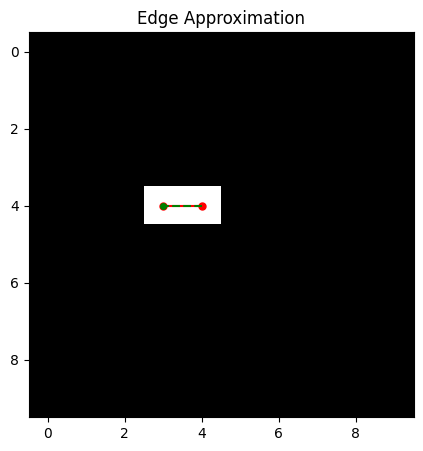

In [134]:
edge_image = np.array([
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 255, 255,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 0)
print('edge_points', edge_points)
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)

startPoint Indexes [0]
edge_points [[(0, 0), (0, 9), (9, 9), (9, 0), (1, 0), (0, 0)]]
feed_points [[True, True, True, True, True, False]]


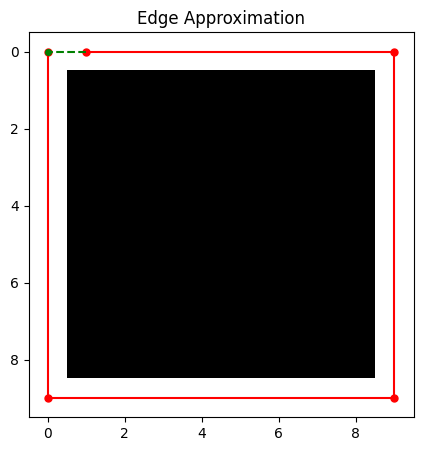

In [135]:
edge_image = np.array([
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 0)
print('edge_points', edge_points)
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)

startPoint Indexes [0]
edge_points (0, 0),(0, 9),(9, 9),(9, 0),(4, 5),(1, 1),(0, 0)


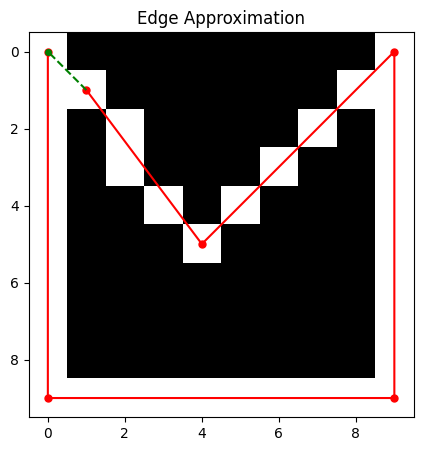

In [136]:
edge_image = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255,   0,   0,   0,   0,   0,   0, 255, 255],
       [255,   0, 255,   0,   0,   0,   0, 255,   0, 255],
       [255,   0, 255,   0,   0,   0, 255,   0,   0, 255],
       [255,   0,   0, 255,   0, 255,   0,   0,   0, 255],
       [255,   0,   0,   0, 255,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 3)
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
plot_edge_approx2(edge_image, edge_points, feed_points)

In [137]:
edge_image = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255,   0,   0,   0,   0,   0, 255, 255, 255],
       [255,   0, 255,   0,   0,   0, 255,   0,   0, 255],
       [255,   0,   0, 255,   0, 255,   0,   0,   0, 255],
       [255,   0,   0,   0, 255,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 0)
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
print('feed_points', feed_points)
# plot_edge_approx2(edge_image, edge_points, feed_points)

startPoint Indexes [0]
edge_points (0, 0),(0, 9),(9, 9),(9, 0),(9, 1),(8, 2),(7, 2),(4, 5),(0, 1),(0, 0)
feed_points [[True, True, True, True, False, True, True, True, True, True]]


startPoint Indexes [0]
edge_points (0, 0),(0, 9),(9, 9),(9, 0),(4, 5),(0, 1),(0, 0)
feed_points [[True, True, True, True, True, True, True]]


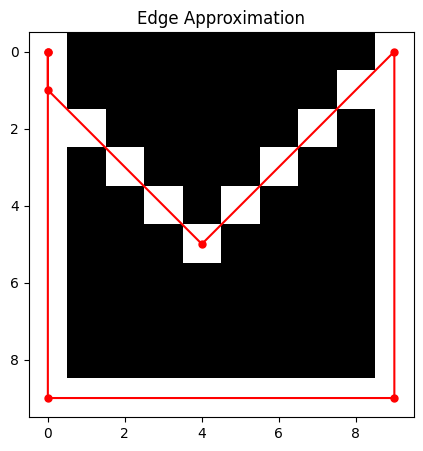

In [138]:
edge_image = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0, 255, 255],
       [255, 255,   0,   0,   0,   0,   0, 255,   0, 255],
       [255,   0, 255,   0,   0,   0, 255,   0,   0, 255],
       [255,   0,   0, 255,   0, 255,   0,   0,   0, 255],
       [255,   0,   0,   0, 255,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 0)
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)

startPoint Indexes [0]
edge_points (0, 0),(0, 9),(9, 9),(9, 0),(9, 4),(8, 5),(1, 5),(0, 4),(0, 1),(0, 0)
feed_points [[True, True, True, True, False, True, True, True, False, False]]


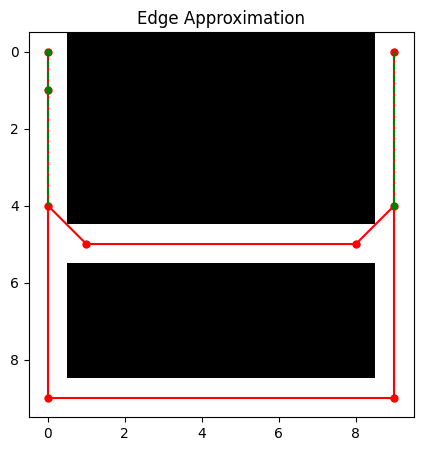

In [139]:
edge_image = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 0)
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)

startPoint Indexes [0]
edge_points (1, 0),(1, 3),(2, 4),(1, 5),(2, 6),(1, 7),(2, 8),(9, 8),(9, 0),(9, 3),(8, 4),(2, 4),(1, 3),(1, 1),(1, 0)
feed_points [[True, True, True, True, True, True, True, True, True, False, True, True, True, False, True]]


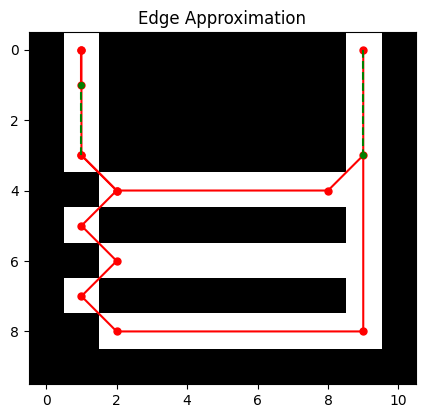

In [140]:
edge_image = np.array([
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255, 255,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 0)
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)

startPoint Indexes [0]
edge_points (0, 0),(0, 1),(0, 0)
feed_points [[True, True, True]]


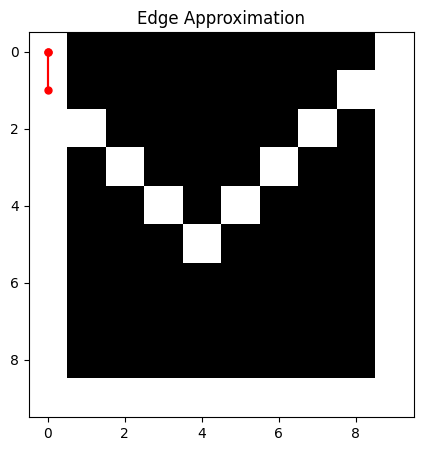

In [141]:
# Palidrom Problem
edge_image = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0, 255, 255],
       [255, 255,   0,   0,   0,   0,   0, 255,   0, 255],
       [255,   0, 255,   0,   0,   0, 255,   0,   0, 255],
       [255,   0,   0, 255,   0, 255,   0,   0,   0, 255],
       [255,   0,   0,   0, 255,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 10)
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)

duration 2.3425991535186768
edge_points [[(750, 765), (750, 765)], [(504, 766), (509, 767), (504, 766)], [(737, 764), (743, 767), (737, 764)], [(721, 765), (730, 767), (721, 765)], [(599, 764), (604, 767), (599, 764)], [(520, 764), (520, 764)], [(663, 763), (663, 763)], [(556, 763), (575, 767), (556, 763)], [(516, 763), (516, 763)], [(428, 762), (428, 762)], [(478, 765), (461, 767), (478, 765)], [(179, 760), (183, 764), (179, 760)], [(472, 759), (472, 759)], [(404, 760), (388, 767), (404, 760)], [(371, 761), (359, 764), (371, 761)], [(311, 759), (315, 767), (318, 761), (311, 759)], [(646, 759), (660, 763), (646, 759)], [(588, 759), (575, 763), (588, 759)], [(359, 758), (336, 762), (346, 761), (342, 767), (353, 761), (355, 767), (359, 758)], [(714, 760), (694, 761), (711, 767), (706, 759), (714, 760)], [(269, 759), (284, 756), (277, 764), (284, 765), (279, 758), (293, 758), (269, 759)], [(520, 758), (534, 758), (521, 767), (529, 761), (546, 767), (536, 763), (538, 755), (536, 763), (533

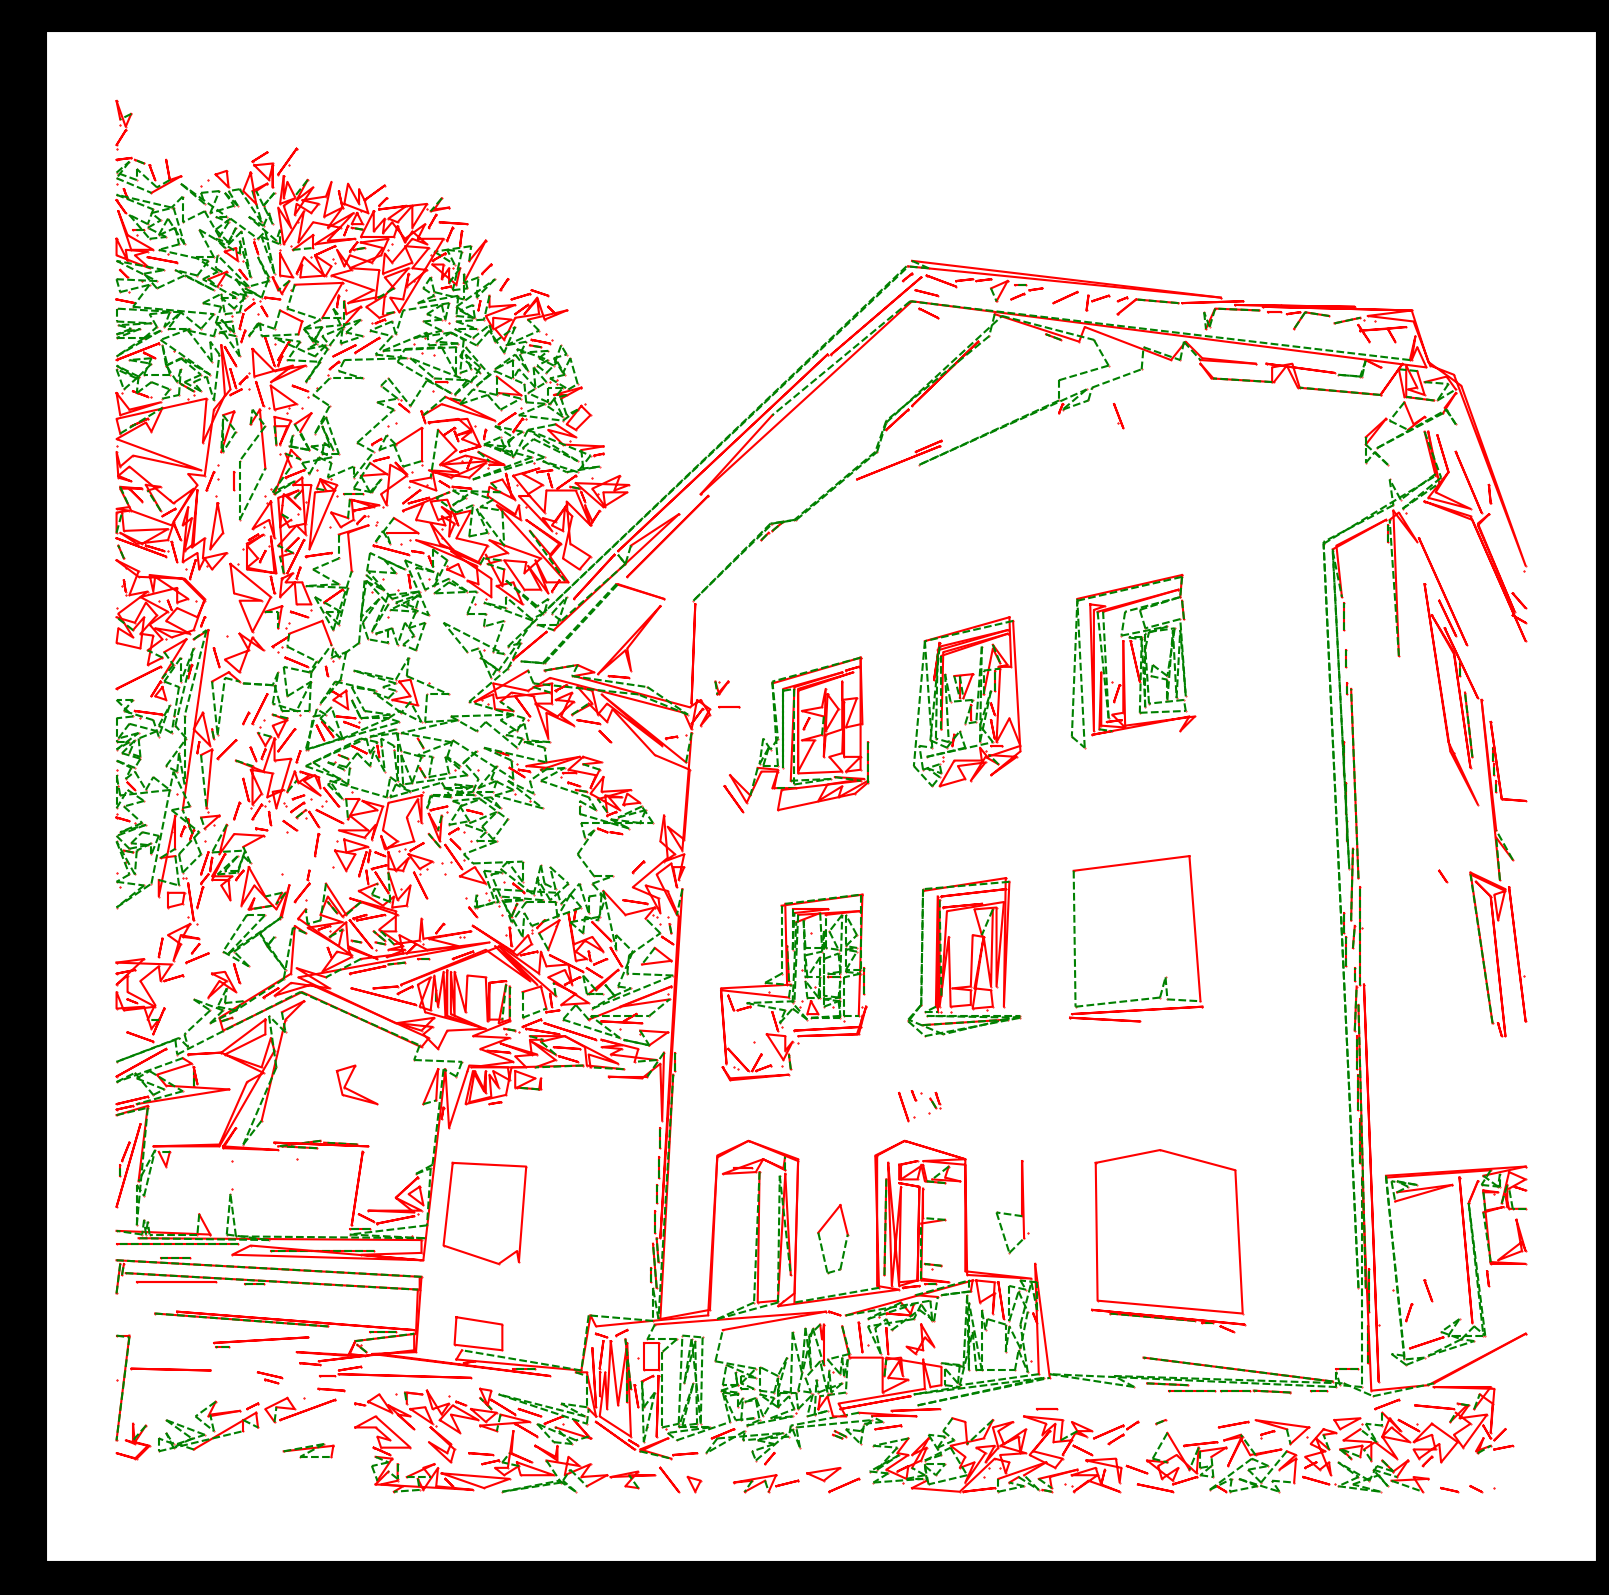

In [4]:
import base64
import time

preloaded_images = None
with open("../../preloaded_images.txt", "r") as file:
    preloaded_images = eval(file.read())
selected_diff_image = preloaded_images[2]

# Convert image
decoded_image = base64.b64decode(selected_diff_image.split(',')[1])
image_array = np.frombuffer(decoded_image, dtype=np.uint8)
origial = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Graustufenbild
gray = cv2.cvtColor(origial, cv2.COLOR_BGR2GRAY)

edge_image = cv2.Canny(gray, 50, 150)

start_time = time.time()
edge_points, feed_points = getContourApproximation2(edge_image, 5, 5)
print('duration', time.time() - start_time)

print('edge_points', edge_points)
print('feed_points', feed_points)

params = {
    'plot_edge_image': False,
    'showG0Points': False,
    'showG1Points': True,
    'showG0Lines': True,
    'showG1Lines': True
}
plot_edge_approx2(edge_image, edge_points, feed_points, (20, 20), params)

In [ ]:
params = {
    'plot_edge_image': False,
    'showG0Points': False,
    'showG1Points': True,
    'showG0Lines': False,
    'showG1Lines': True
}
plot_edge_approx2(edge_image, edge_points, feed_points, (20, 20), params)

In [147]:
import base64
import time

preloaded_images = None
with open("../../preloaded_images.txt", "r") as file:
    preloaded_images = eval(file.read())
selected_diff_image = preloaded_images[2]

# Convert image
decoded_image = base64.b64decode(selected_diff_image.split(',')[1])
image_array = np.frombuffer(decoded_image, dtype=np.uint8)
origial = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Graustufenbild
gray = cv2.cvtColor(origial, cv2.COLOR_BGR2GRAY)

edge_image = cv2.Canny(gray, 50, 150)

start_time = time.time()
edge_points, feed_points = getContourApproximation2(edge_image, 5, 5)
print('duration', time.time() - start_time)

print('edge_points', edge_points)
print('feed_points', feed_points)

duration 2.327353000640869
edge_points [[(750, 765), (749, 766), (750, 765)], [(505, 765), (506, 766), (505, 765)], [(737, 764), (738, 765), (737, 764)], [(724, 764), (725, 764), (724, 764)], [(599, 764), (600, 764), (599, 764)], [(518, 764), (519, 764), (518, 764)], [(662, 763), (663, 763), (662, 763)], [(557, 762), (558, 762), (557, 762)], [(515, 762), (516, 763), (515, 762)], [(428, 762), (429, 762), (428, 762)], [(474, 761), (461, 767), (475, 762), (474, 761)], [(179, 760), (180, 760), (179, 760)], [(472, 759), (472, 760), (472, 759)], [(401, 759), (388, 767), (402, 760), (401, 759)], [(367, 759), (368, 759), (367, 759)], [(311, 759), (314, 767), (318, 761), (312, 759), (311, 759)], [(653, 757), (646, 759), (658, 763), (654, 757), (653, 757)], [(584, 757), (575, 763), (584, 758), (584, 757)], [(355, 757), (337, 761), (347, 762), (340, 767), (352, 761), (355, 767), (356, 757), (355, 757)], [(706, 756), (705, 762), (694, 761), (712, 766), (707, 758), (714, 760), (707, 756), (706, 756

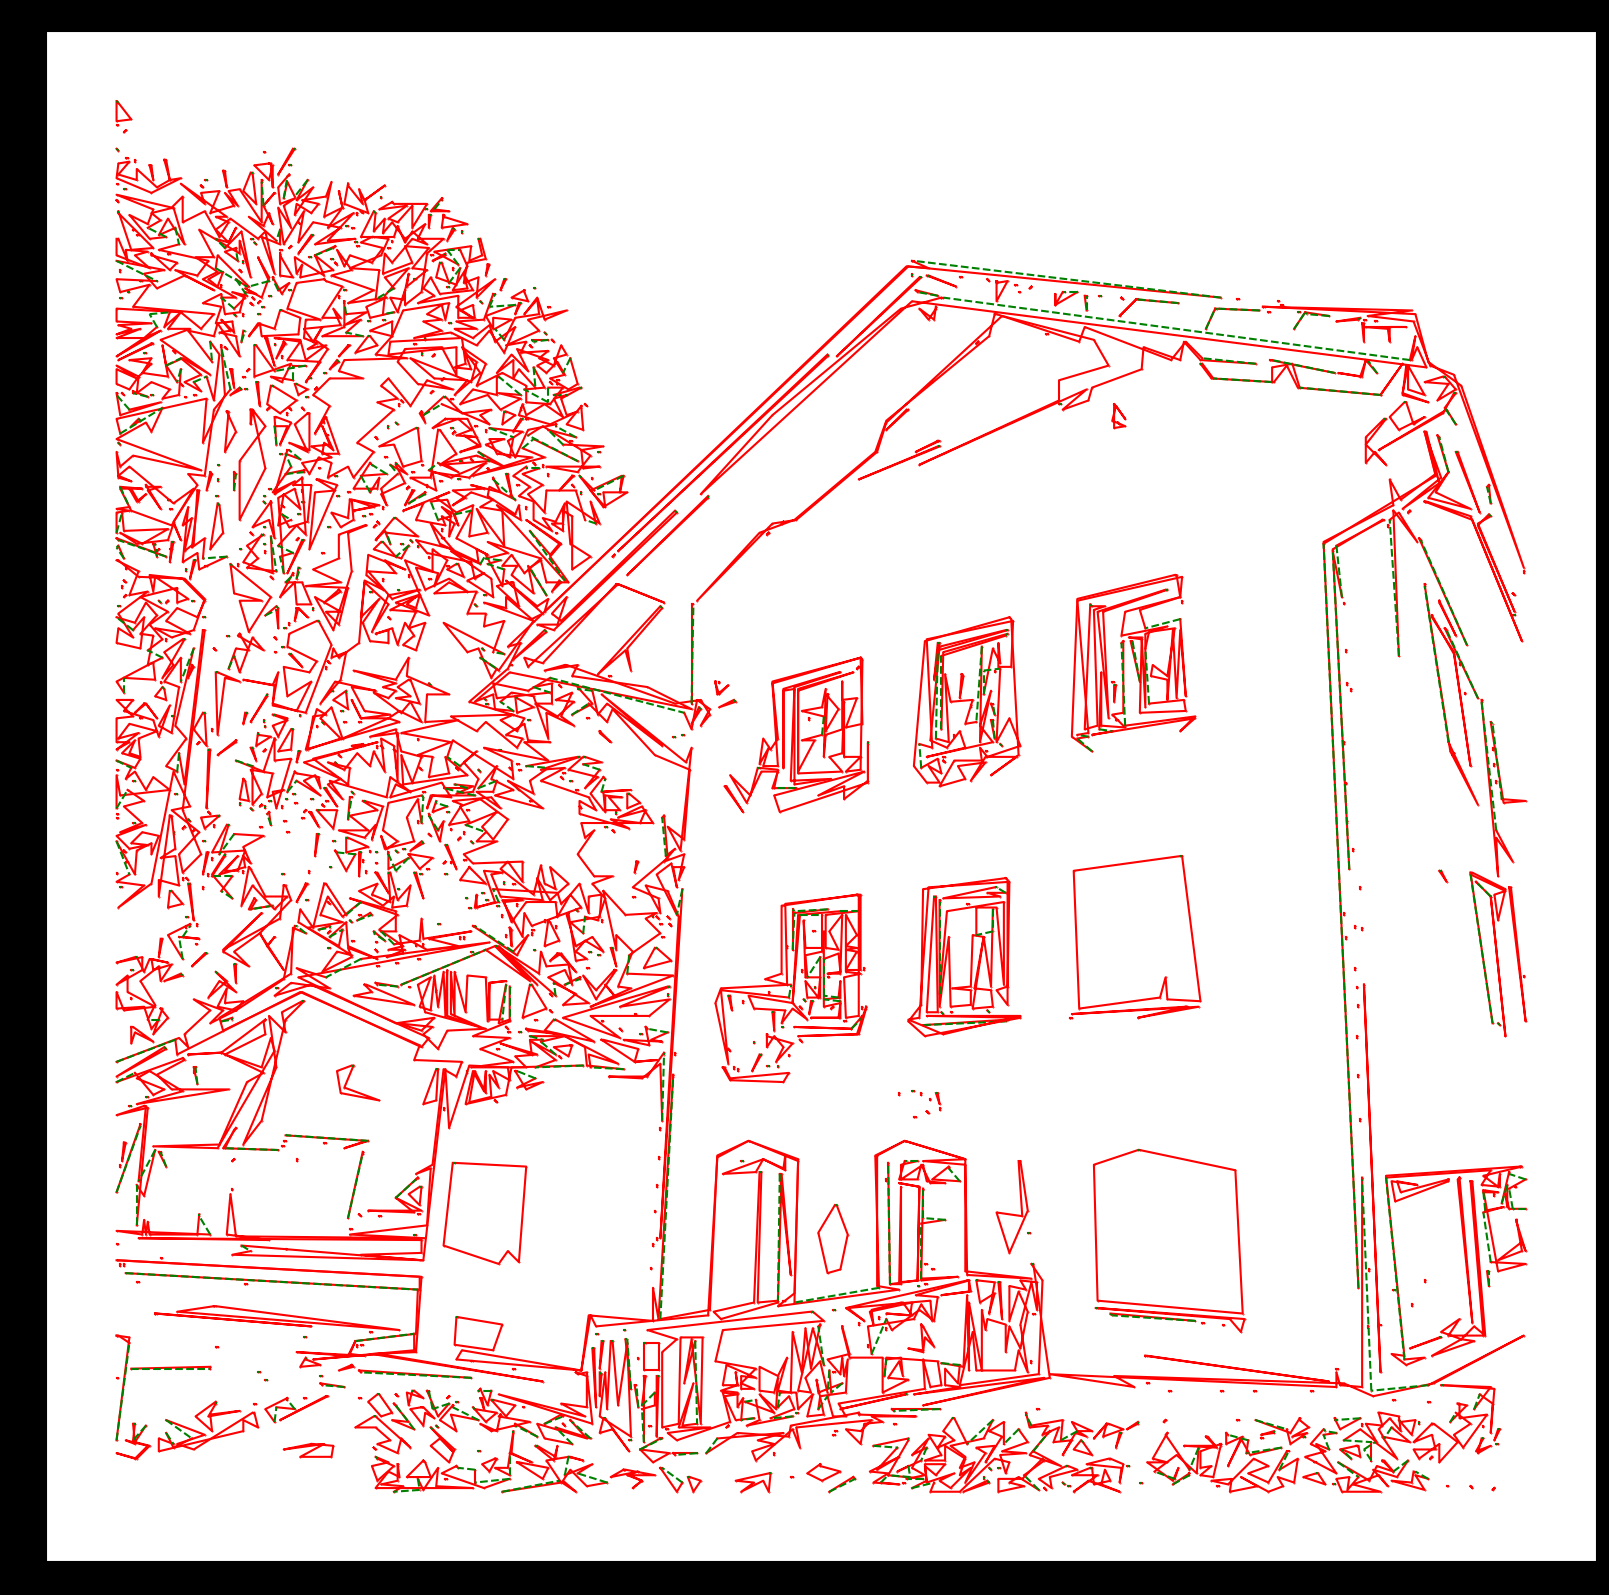

In [148]:
params = {
    'plot_edge_image': False,
    'showG0Points': False,
    'showG1Points': True,
    'showG0Lines': True,
    'showG1Lines': True
}
plot_edge_approx2(edge_image, edge_points, feed_points, (20, 20), params)

In [96]:
index = max(range(len(feed_points)), key=lambda i: feed_points[i].count(False))

In [100]:
print(edge_points[index])
print(feed_points[index])

[(245, 124), (233, 129), (229, 117), (222, 126), (229, 118), (230, 126), (217, 128), (211, 140), (206, 134), (215, 129), (205, 128), (205, 134), (201, 127), (217, 121), (203, 122), (203, 116), (200, 129), (185, 130), (196, 134), (184, 134), (194, 139), (203, 132), (206, 141), (217, 133), (211, 147), (203, 135), (196, 143), (182, 136), (162, 139), (177, 135), (167, 130), (177, 129), (169, 126), (177, 121), (179, 129), (181, 120), (156, 124), (152, 137), (150, 130), (138, 135), (150, 138), (141, 148), (158, 150), (124, 151), (121, 157), (134, 161), (116, 161), (107, 170), (116, 176), (108, 191), (114, 182), (121, 202), (112, 202), (113, 196), (118, 200), (112, 187), (116, 197), (106, 198), (117, 204), (101, 207), (105, 213), (110, 204), (117, 207), (115, 215), (129, 209), (129, 215), (140, 201), (131, 196), (151, 178), (142, 174), (153, 172), (144, 165), (148, 161), (160, 176), (169, 162), (182, 169), (153, 152), (157, 145), (177, 144), (185, 159), (185, 144), (145, 146), (169, 136), (17

In [103]:
list(zip(edge_points[index], feed_points[index]))

[((245, 124), True),
 ((233, 129), True),
 ((229, 117), True),
 ((222, 126), True),
 ((229, 118), True),
 ((230, 126), True),
 ((217, 128), True),
 ((211, 140), False),
 ((206, 134), False),
 ((215, 129), True),
 ((205, 128), True),
 ((205, 134), True),
 ((201, 127), False),
 ((217, 121), True),
 ((203, 122), False),
 ((203, 116), False),
 ((200, 129), False),
 ((185, 130), False),
 ((196, 134), False),
 ((184, 134), False),
 ((194, 139), False),
 ((203, 132), False),
 ((206, 141), False),
 ((217, 133), False),
 ((211, 147), False),
 ((203, 135), False),
 ((196, 143), False),
 ((182, 136), False),
 ((162, 139), False),
 ((177, 135), False),
 ((167, 130), False),
 ((177, 129), False),
 ((169, 126), False),
 ((177, 121), False),
 ((179, 129), False),
 ((181, 120), False),
 ((156, 124), False),
 ((152, 137), False),
 ((150, 130), False),
 ((138, 135), False),
 ((150, 138), False),
 ((141, 148), False),
 ((158, 150), False),
 ((124, 151), False),
 ((121, 157), False),
 ((134, 161), False),

In [106]:
print('\n'.join([str(x) for x in list(zip(edge_points[index], feed_points[index]))]))

((245, 124), True)
((233, 129), True)
((229, 117), True)
((222, 126), True)
((229, 118), True)
((230, 126), True)
((217, 128), True)
((211, 140), False)
((206, 134), False)
((215, 129), True)
((205, 128), True)
((205, 134), True)
((201, 127), False)
((217, 121), True)
((203, 122), False)
((203, 116), False)
((200, 129), False)
((185, 130), False)
((196, 134), False)
((184, 134), False)
((194, 139), False)
((203, 132), False)
((206, 141), False)
((217, 133), False)
((211, 147), False)
((203, 135), False)
((196, 143), False)
((182, 136), False)
((162, 139), False)
((177, 135), False)
((167, 130), False)
((177, 129), False)
((169, 126), False)
((177, 121), False)
((179, 129), False)
((181, 120), False)
((156, 124), False)
((152, 137), False)
((150, 130), False)
((138, 135), False)
((150, 138), False)
((141, 148), False)
((158, 150), False)
((124, 151), False)
((121, 157), False)
((134, 161), False)
((116, 161), False)
((107, 170), False)
((116, 176), False)
((108, 191), False)
((114, 182)

In [93]:
my_list = [[True, True, True], [True, True, False], [False, False, False], [True, False, False]]

max(range(len(my_list)), key=lambda i: my_list[i].count(False))

2